# Example of usage Spark OCR for de-identify Dicom documents using ImageToTextV2

## Install spark-ocr python packge
Need specify:
- license
- path to `spark-ocr-assembly-[version].jar` and `spark-nlp-jsl-[version]`
- or `secret` for Spark OCR and `nlp_secret` for Spark NLP Internal
- `aws_access_key` and `aws_secret_key`for download pretrained models

For more details about Dicom de-identification please read:

 - [DICOM de-identification at scale in Visual NLP — Part 1.](https://medium.com/john-snow-labs/dicom-de-identification-at-scale-in-visual-nlp-part-1-68784177f5f0)

 - [DICOM de-identification at scale in Visual NLP — Part 2.](https://medium.com/john-snow-labs/dicom-de-identification-at-scale-in-visual-nlp-part-2-361af5e36412)

 - [DICOM de-identification at scale in Visual NLP — Part 3.](https://medium.com/john-snow-labs/dicom-de-identification-at-scale-in-visual-nlp-part-3-61cecc3adb56)

In [1]:
license = ""
secret = ""
nlp_secret = ""
aws_access_key = ""
aws_secret_key = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../../target/scala-2.12"

## Initialization of spark session

In [2]:
from sparkocr import start

if license:
    os.environ['JSL_OCR_LICENSE'] = license
    os.environ['SPARK_NLP_LICENSE'] = license

if aws_access_key:
    os.environ['AWS_ACCESS_KEY'] = aws_access_key
    os.environ['AWS_SECRET_ACCESS_KEY'] = aws_secret_key


spark = start(secret=secret,
              nlp_secret=nlp_secret,
              jar_path=spark_ocr_jar_path,
              nlp_internal="6.2.2")

spark

Spark version: 3.4.1
Spark NLP version: 6.2.2
Spark NLP for Healthcare version: 6.1.0
Spark OCR version: 6.2.2rc1



## Import Spark OCR transformers and Spark NLP annotators

In [3]:
import os
import sys

from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp_jsl
from sparknlp_jsl.annotator import *

import sparkocr
from sparkocr.transformers import *
from sparkocr.utils import *
from sparkocr.enums import *

from pyspark.ml import PipelineModel, Pipeline

print(f"Spark NLP version: {sparknlp.version()}")
print(f"Spark NLP internal version: {sparknlp_jsl.version()}")
print(f"Spark OCR version: {sparkocr.version()}")

Spark NLP version: 6.2.2
Spark NLP internal version: 6.1.0
Spark OCR version: 6.2.2rc1


## Define de-identification  NLP pipeline

In [4]:
def deidentification_nlp_pipeline(input_column, prefix = "", model="ner_deid_large"):
    document_assembler = DocumentAssembler() \
        .setInputCol(input_column) \
        .setOutputCol(prefix + "document_raw")

    cleanUpPatterns = ["<[^>]>"]
    documentNormalizer = DocumentNormalizer() \
      .setInputCols(prefix + "document_raw") \
      .setOutputCol(prefix + "document") \
      .setAction("clean") \
      .setPatterns(cleanUpPatterns) \
      .setReplacement(" ") \
      .setPolicy("pretty_all")

    # Sentence Detector annotator, processes various sentences per line
    sentence_detector = SentenceDetector() \
        .setInputCols([prefix + "document"]) \
        .setOutputCol(prefix + "sentence")

    tokenizer = Tokenizer() \
        .setInputCols([prefix + "sentence"]) \
        .setOutputCol(prefix + "token")

    # Clinical word embeddings
    word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token"]) \
        .setOutputCol(prefix + "embeddings")

    clinical_ner = MedicalNerModel.pretrained(model, "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "embeddings"]) \
        .setOutputCol(prefix + "ner")

    custom_ner_converter = NerConverter() \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "ner"]) \
        .setOutputCol(prefix + "ner_chunk") \
        .setWhiteList(['NAME', 'AGE', 'CONTACT',
                   'LOCATION', 'PROFESSION', 'PERSON', 'DATE', 'DOCTOR'])

    nlp_pipeline = Pipeline(stages=[
            document_assembler,
            documentNormalizer,
            sentence_detector,
            tokenizer,
            word_embeddings,
            clinical_ner,
            custom_ner_converter
        ])
    empty_data = spark.createDataFrame([[""]]).toDF(input_column)
    nlp_model = nlp_pipeline.fit(empty_data)
    return nlp_model

## Define OCR transformers and pipeline for image deidentification

In [22]:
from pyspark.ml import PipelineModel, Pipeline

dicom_to_image = DicomToImageV3() \
    .setInputCols(["content"]) \
    .setOutputCol("image_raw") \
    .setKeepInput(True)

text_detector = ImageTextDetectorV2 \
    .pretrained("image_text_detector_v2", "en", "clinical/ocr") \
    .setInputCol("image_raw") \
    .setOutputCol("text_regions") \
    .setWithRefiner(False) \
    .setLinkThreshold(0.3)

ocr = ImageToTextV2.pretrained("ocr_base_printed_v2_opt", "en", "clinical/ocr") \
    .setRegionsColumn("text_regions") \
    .setInputCols(["image_raw"]) \
    .setOutputCol("text") \
    .setOutputFormat("text_with_positions") \
    .setGroupImages(False)

# Found coordinates of sensitive data
position_finder = PositionFinder() \
    .setInputCols("ner_chunk") \
    .setOutputCol("coordinates") \
    .setPageMatrixCol("positions") \
    .setOcrScaleFactor(1.0)

# Draw filled rectangle for hide sensitive data
draw_regions = DicomDrawRegions() \
    .setInputCol("content") \
    .setInputRegionsCol("coordinates") \
    .setOutputCol("dicom") \
    .setAggCols(["path", "content", "text"]) \
    .setKeepInput(True)

dicom_deidentifier = DicomMetadataDeidentifier() \
    .setInputCol("dicom") \
    .setOutputCol("dicom_cleaned")\
    .setKeepInput(True)

# OCR pipeline
pipeline = PipelineModel(stages=[
    dicom_to_image,
    text_detector,
    ocr,
    deidentification_nlp_pipeline(input_column="text", prefix="", model="ner_deid_generic_augmented"),
    position_finder
])

image_text_detector_v2 download started this may take some time.
Approximate size to download 75.3 MB
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_deid_generic_augmented download started this may take some time.
Approximate size to download 13.8 MB
[OK!]


## Read dicom objects as binary file and display metadata

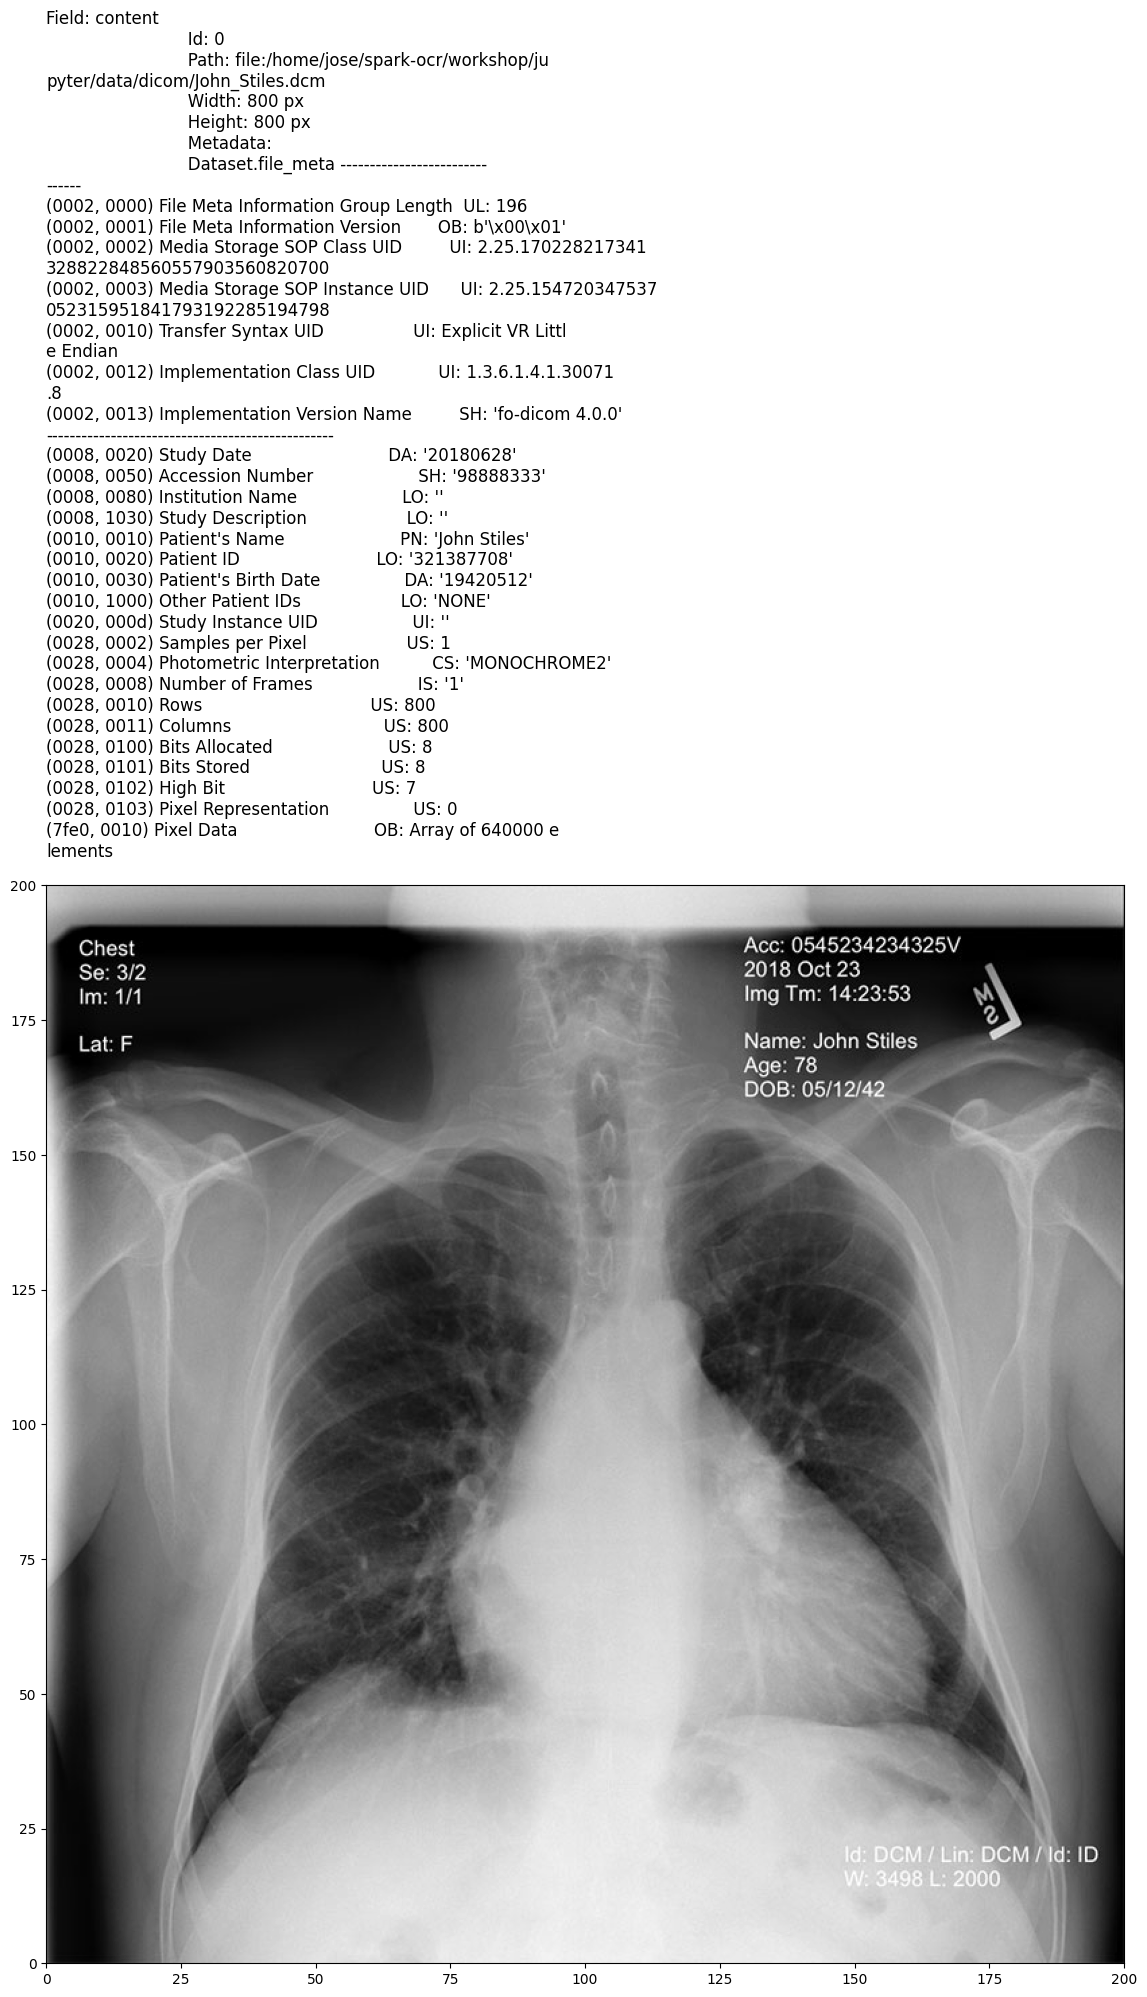

In [29]:
dicom_path = './../data/dicom/J*.dcm'
dicom_df = spark.read.format("binaryFile").load(dicom_path).limit(1)

display_dicom(dicom_df, limit=1)

In [30]:
result = pipeline.transform(dicom_df).cache()

/home/jose/.local/lib/python3.8/site-packages/pyspark/sql/dataframe.py:169: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


## Inspect Intermediate Stages

In [31]:
result.printSchema()

root
 |-- text_regions: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- index: integer (nullable = false)
 |    |    |-- page: integer (nullable = false)
 |    |    |-- x: float (nullable = false)
 |    |    |-- y: float (nullable = false)
 |    |    |-- width: float (nullable = false)
 |    |    |-- height: float (nullable = false)
 |    |    |-- score: float (nullable = false)
 |    |    |-- label: string (nullable = false)
 |    |    |-- angle: float (nullable = false)
 |    |    |-- rotated: boolean (nullable = false)
 |-- pagenum: integer (nullable = true)
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- image_raw: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- 

In [32]:
import pandas as pd
pd.set_option('display.max_colwidth', 500)
result.select("exception", "text", "text_regions", "ner", "coordinates").toPandas()

,exception,text,text_regions,ner,coordinates
0,,CHEST ACC: 0545234234325V\nSE: 3/2 2018 OCT 23\nIM: 1/1 IMG TM: 14:23:53 M\nLAT: F NAME: JOHN STILES\nAGE: 78\nDOB: 05/12/42\nID: DCM / LIM: DCM / ID: ID\nW: 3498 L: 2000,"[(0, 0, 45.625, 46.25, 43.75, 15.0, 0.0, , 0.0, True), (0, 0, 599.375, 44.375, 163.75, 16.25, 0.0, , 0.0, True), (0, 0, 50.0, 65.0, 52.5, 15.0, 0.0, , 0.0, True), (0, 0, 561.875, 63.125, 88.75, 16.25, 0.0, , 0.0, True), (0, 0, 47.5, 82.5, 50.0, 15.0, 0.0, , 0.0, True), (0, 0, 579.15234375, 82.0382308959961, 127.07376098632812, 19.961063385009766, 0.0, , 0.398840069770813, True), (0, 0, 698.2821044921875, 89.11925506591797, 17.16811180114746, 34.6921501159668, 0.0, , -12.99465274810791, True)...","[(named_entity, 0, 4, O, {'sentence': '0', 'word': 'CHEST', 'confidence': '0.9996'}, []), (named_entity, 6, 8, O, {'sentence': '0', 'word': 'ACC', 'confidence': '0.9969'}, []), (named_entity, 9, 9, O, {'sentence': '0', 'word': ':', 'confidence': '0.9999'}, []), (named_entity, 11, 24, B-ID, {'sentence': '0', 'word': '0545234234325V', 'confidence': '0.9998'}, []), (named_entity, 26, 27, O, {'sentence': '0', 'word': 'SE', 'confidence': '0.9972'}, []), (named_entity, 28, 28, O, {'sentence': '0',...","[(0, 0, 53.75, 56.07143020629883, 495.7791748046875, 15.714285850524902, 0.0, 0, 0.0, False), (1, 0, 563.38232421875, 107.5, 84.11767578125, 15.0, 0.0, 0, 0.0, False), (2, 0, 558.5714111328125, 126.25, 16.4285888671875, 17.5, 0.0, 0, 0.0, False), (3, 0, 558.8461303710938, 143.75, 66.15386962890625, 16.25, 0.0, 0, 0.0, False), (4, 0, 616.0, 730.0, 31.33331298828125, 15.0, 0.0, 0, 0.0, False), (5, 0, 678.6666870117188, 730.0, 31.33331298828125, 15.0, 0.0, 0, 0.0, False)]"


## Add missing transformers & Display dicom
We removed these because we wanted to inspect intermediate results like in the previous cell.

/home/jose/.local/lib/python3.8/site-packages/pydicom/valuerep.py:443: UserWarning: The value length (44) exceeds the maximum length of 16 allowed for VR SH.
  warnings.warn(msg)


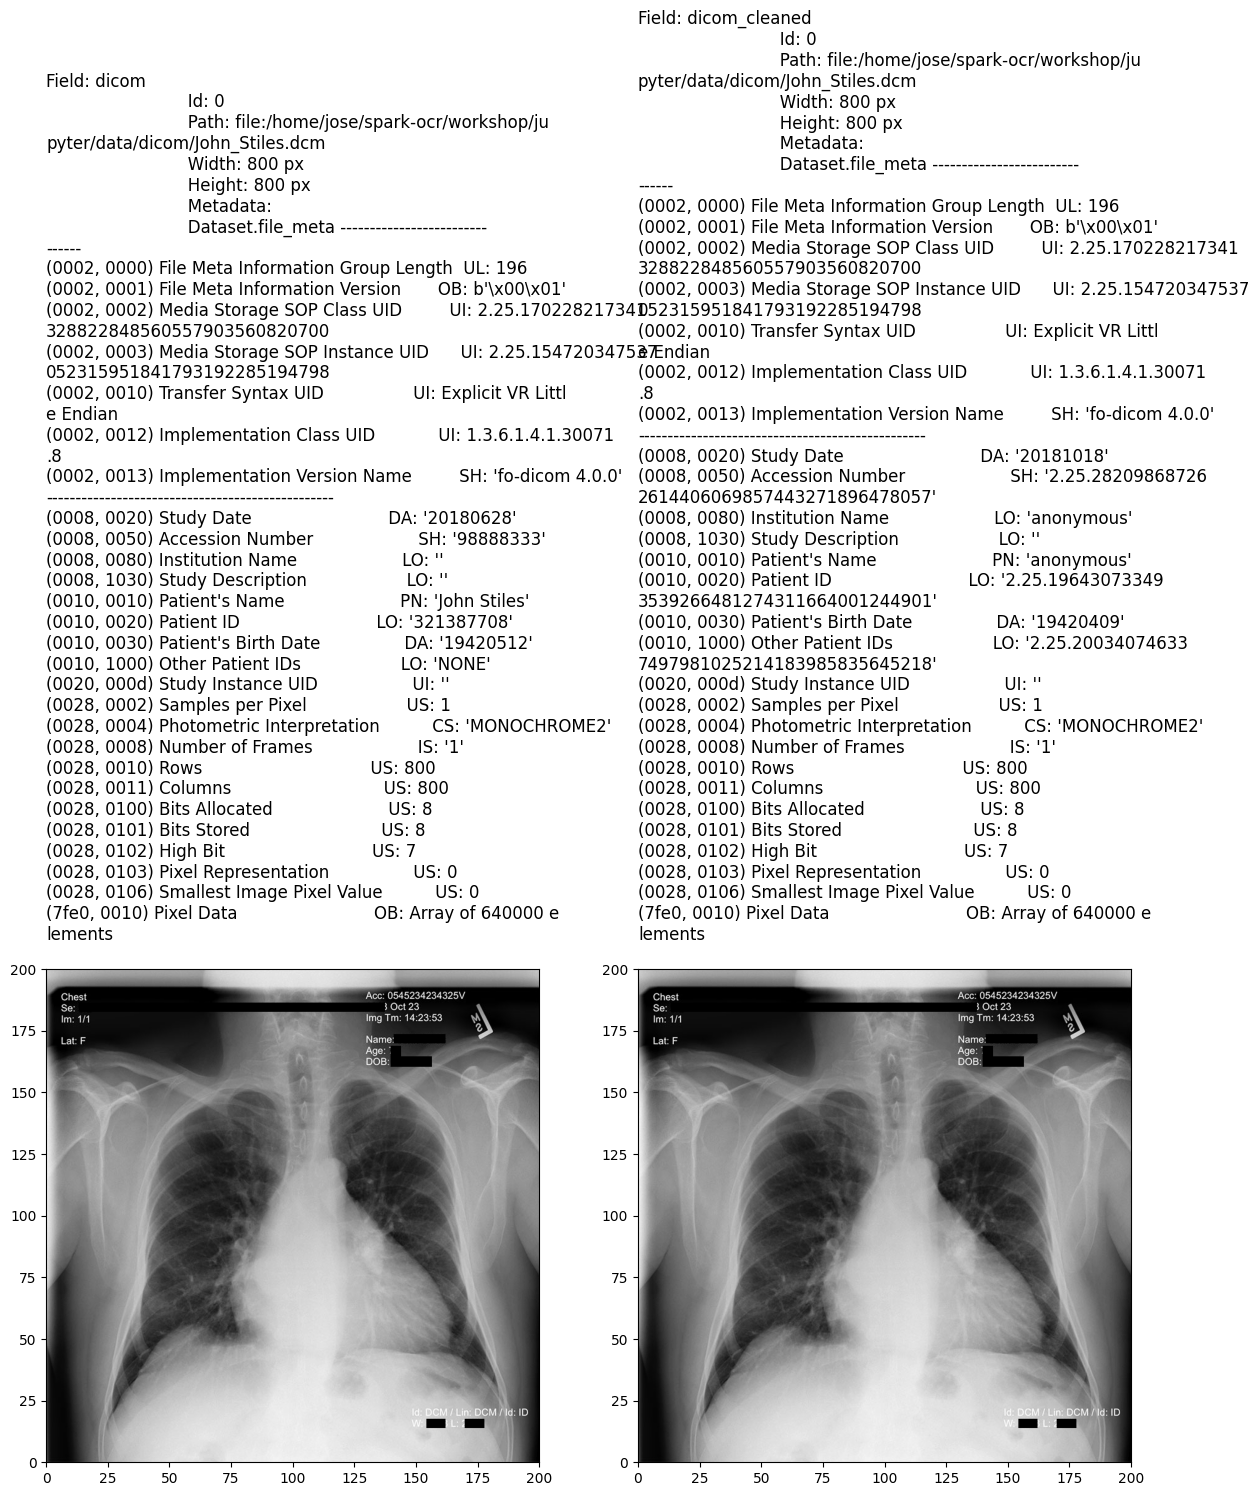

In [39]:
pipeline.stages.extend([draw_regions, dicom_deidentifier])
result = pipeline.transform(dicom_df).cache()
display_dicom(result, "dicom, dicom_cleaned")

## Write results back to disk

In [40]:
# NBVAL_SKIP
output_path = "./../data/dicom/deidentified/"
from pyspark.sql.functions import *

def get_name(path, keep_subfolder_level=0):
    path = path.split("/")
    path[-1] = path[-1].split('.')[0]
    return "/".join(path[-keep_subfolder_level-1:])

result.withColumn("fileName", udf(get_name, StringType())(col("path"))) \
    .write \
    .format("binaryFormat") \
    .option("type", "dicom") \
    .option("field", "dicom_cleaned") \
    .option("prefix", "ocr_") \
    .option("nameField", "fileName") \
    .mode("overwrite") \
    .save(output_path)

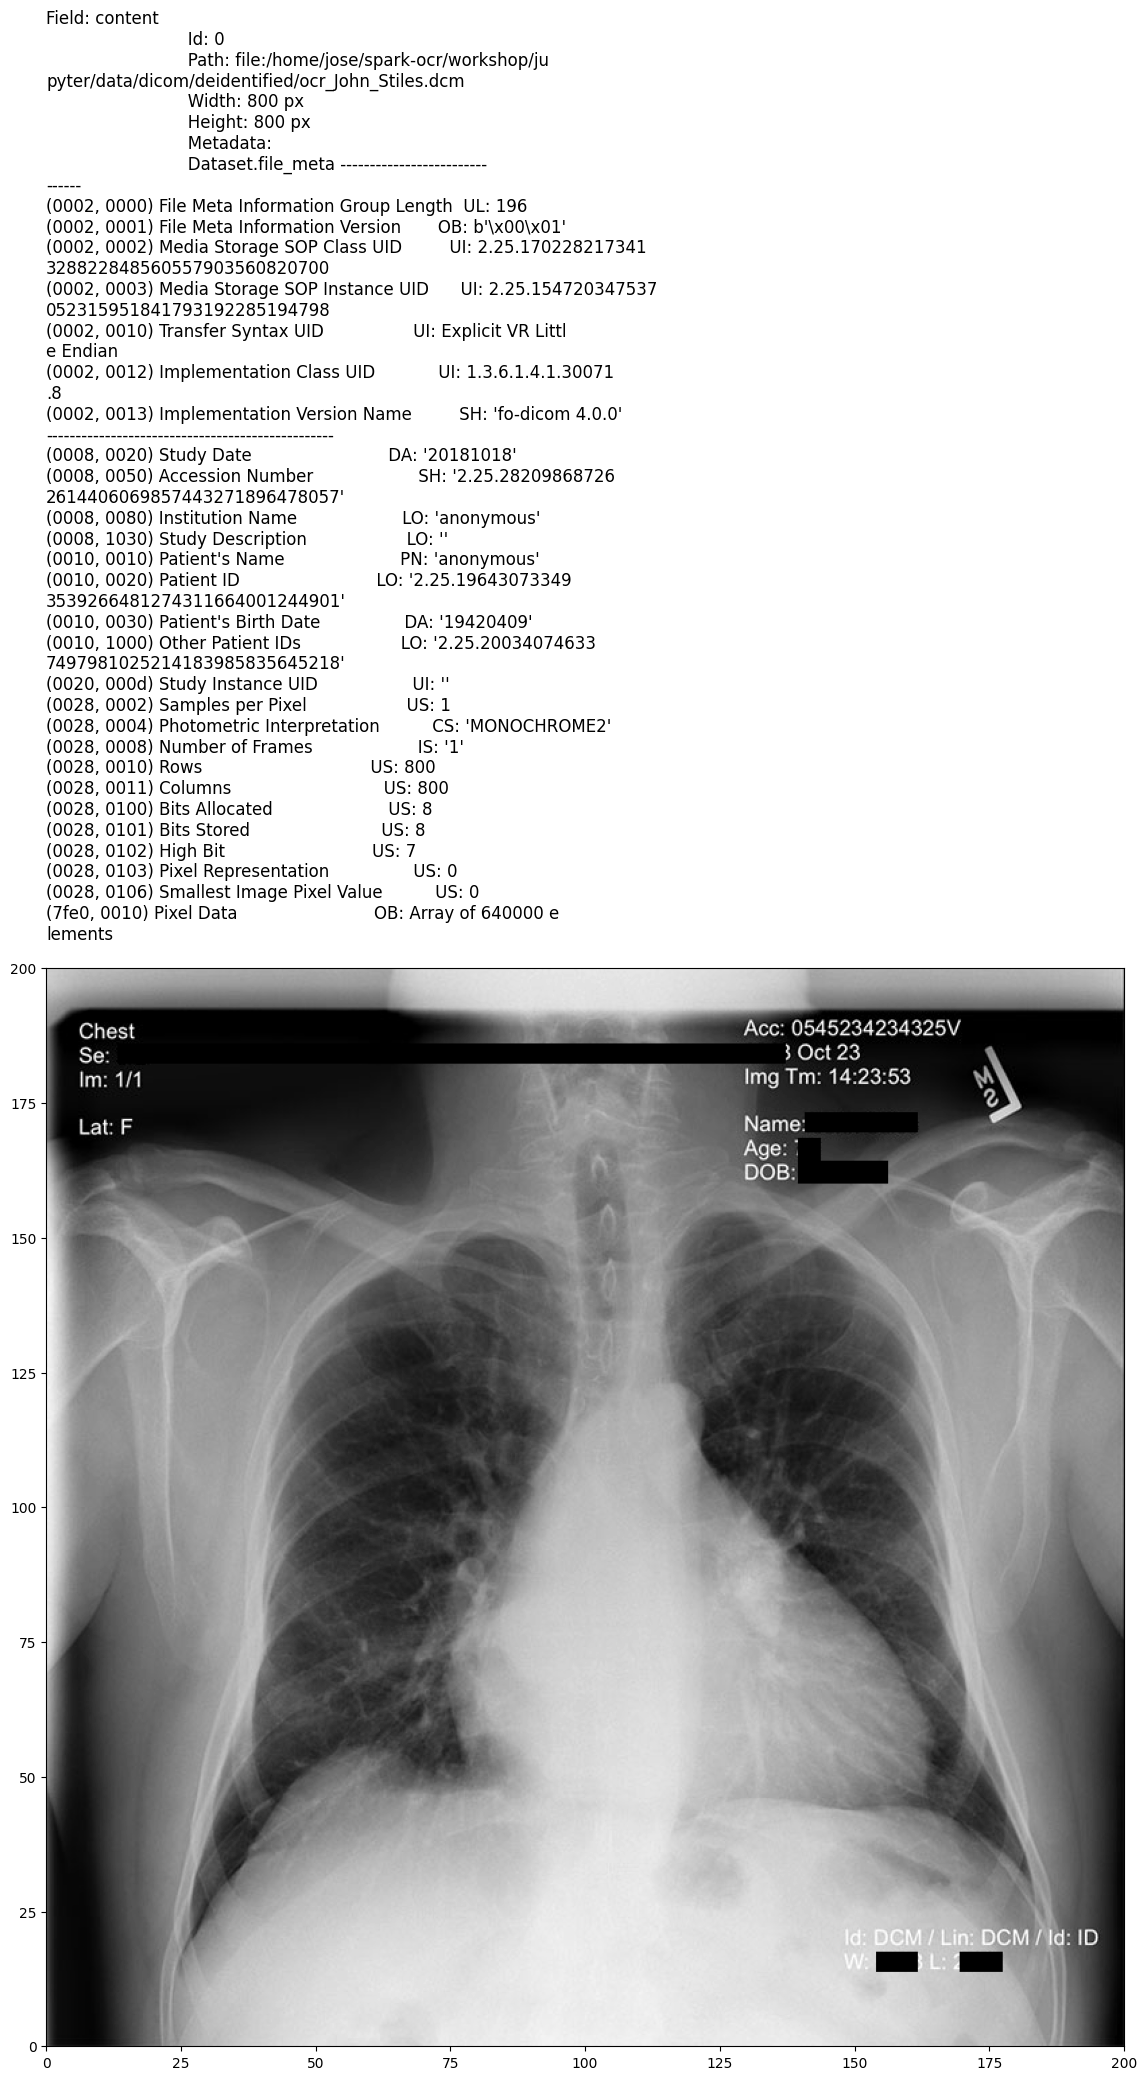

In [41]:
# NBVAL_SKIP
dicom_gen_df = spark.read.format("binaryFile").load("./../data/dicom/deidentified/*.dcm")
display_dicom(dicom_gen_df)

In [ ]:
%%bash
rm -r -f ./../data/dicom/deidentified